Install the `nomad` package from GitHub

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import numpy.random as npr
import random
from shapely.geometry import box
from pprint import pprint
from tqdm import tqdm
import warnings

import nomad.city_gen as cg
from nomad.city_gen import City, Building, Street, RandomCityGenerator
import nomad.traj_gen as tg
from nomad.traj_gen import Agent, Population
import nomad.stop_detection as sd

from nomad.constants import DEFAULT_SPEEDS, FAST_SPEEDS, SLOW_SPEEDS, DEFAULT_STILL_PROBS
from nomad.constants import FAST_STILL_PROBS, SLOW_STILL_PROBS, ALLOWED_BUILDINGS

import os
os.environ['TZ'] = 'UTC'

import pdb

Create City

In [5]:
city_generator = RandomCityGenerator(width=50,
                                     height=50, 
                                     street_spacing=5,
                                     park_ratio=0.05, 
                                     home_ratio=0.4,
                                     work_ratio=0.3, 
                                     retail_ratio=0.25, 
                                     seed=100)
clustered_city = city_generator.generate_city()

In [ ]:
# # Fast city generation - skips expensive street graph computation
# city_generator = RandomCityGenerator(width=100,
#                                      height=100,
#                                      street_spacing=5,
#                                      park_ratio=0.05,
#                                      home_ratio=0.4,
#                                      work_ratio=0.3,
#                                      retail_ratio=0.25,
#                                      seed=100)
# # This will be fast (2-6 minutes) because no street graph computation
# clustered_city = city_generator.generate_city(compute_graph=False)

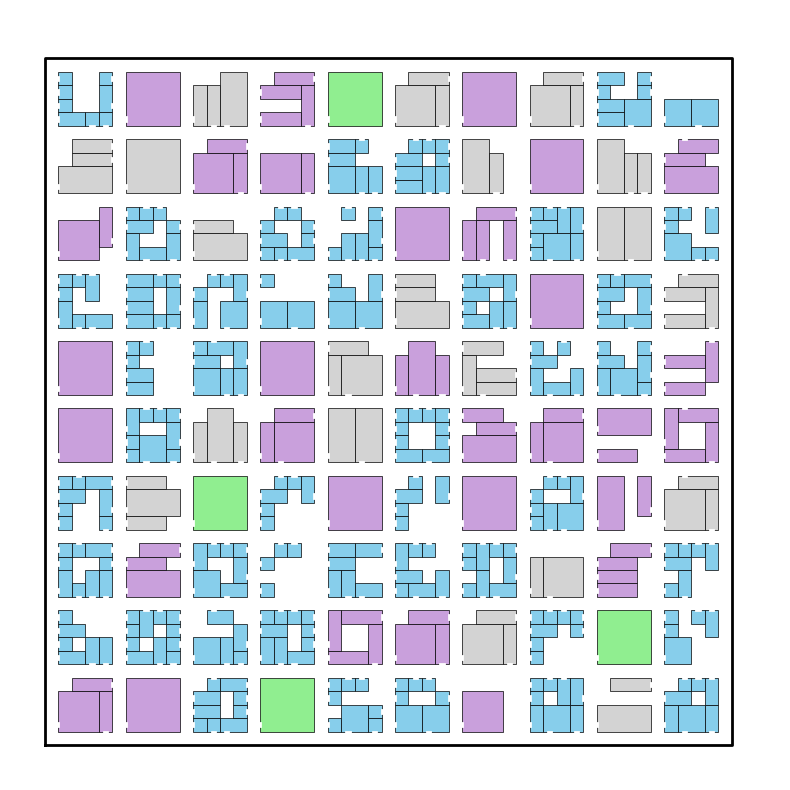

<Figure size 640x480 with 0 Axes>

In [6]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 10))
plt.box(on=False)

clustered_city.plot_city(ax, doors=True, address=False)

# remove axis labels and ticks
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

plt.show()
plt.savefig("random-city.png")

In [ ]:
# # Only compute street graph before trajectory generation
# print("Computing street graph...")
# clustered_city.get_street_graph()

In [5]:
population = Population(clustered_city)
population.generate_agents(N=10000, seed=100)

In [8]:
# Check the actual start time after trajectory generation
test_agent = list(population.roster.values())[0]
test_agent.generate_trajectory(end_time=pd.Timestamp(2025, 1, 8, hour=0, minute=0), seed=100)

print("Start time:", test_agent.trajectory.datetime.min())
print("End time:", test_agent.trajectory.datetime.max())
print("Duration:", test_agent.trajectory.datetime.max() - test_agent.trajectory.datetime.min())

Start time: 2025-01-01 00:01:00+00:00
End time: 2025-01-08 00:00:00+00:00
Duration: 6 days 23:59:00


In [ ]:
# for i, agent_id in enumerate(population.roster):
#     agent = population.roster[agent_id]
#     agent.generate_trajectory(end_time=pd.Timestamp(2025, 1, 8, hour=0, minute=0),
#                               seed=100+i)
#     agent.sample_trajectory(
#         beta_start=300,
#         beta_durations=60,
#         beta_ping=10,
#         seed=100+i)
#     sampled_traj = agent.sparse_traj


# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     for i, agent in enumerate(tqdm(population.roster.values(), desc="Generating trajectories")):
#         agent.generate_trajectory(
#             end_time=pd.Timestamp(2025, 1, 8, hour=0, minute=0),
#             seed=100+i
#         )
#         agent.sample_trajectory(
#             beta_start=300,
#             beta_durations=60,
#             beta_ping=10,
#             seed=100+i
#         )
#         sampled_traj = agent.sparse_traj

from concurrent.futures import ProcessPoolExecutor  # Change this
from itertools import islice  # Add this import
import calendar  # Add this import
from tqdm import tqdm
import warnings
import copy

def process_agent_task(args):
    i, agent = args
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        agent.generate_trajectory(
            end_time=pd.Timestamp(2025, 1, 8, hour=0, minute=0),
            seed=100+i
        )
        agent.sample_trajectory(
            beta_start=300,
            beta_durations=60,
            beta_ping=10,
            seed=100+i
        )
    return agent.name, copy.deepcopy(agent)

start = 0
end = 5000
roster = dict(population.roster)
batch = islice(roster.items(), start, end)

results = []
max_workers = min(16, os.cpu_count()) 

with ProcessPoolExecutor(max_workers=max_workers) as executor:
    with tqdm(total=(end-start), desc="Processing agents") as pbar:
        futures = [
            executor.submit(process_agent_task, (i, agent))
            for i, (agent_id, agent) in enumerate(batch, start=start)
        ]
        for future in futures:
            results.append(future.result())
            pbar.update(1)

# Update population with results
for name, agent in results:
    population.roster[name] = agent

In [ ]:
import boto3
import pickle
import io

# Save city and population to S3
def save_to_s3(obj, bucket, key):
    s3 = boto3.client('s3')
    buffer = io.BytesIO()
    pickle.dump(obj, buffer)
    buffer.seek(0)
    s3.upload_fileobj(buffer, bucket, key)

def load_from_s3(bucket, key):
    s3 = boto3.client('s3')
    buffer = io.BytesIO()
    s3.download_fileobj(bucket, key, buffer)
    buffer.seek(0)
    return pickle.load(buffer)

# Save your data
bucket_name = "your-sagemaker-bucket"  # Replace with your bucket
save_to_s3(clustered_city, bucket_name, "random_city.pkl")
save_to_s3(population, bucket_name, "population.pkl")

In [22]:
Zach = population.roster['nifty_saha']

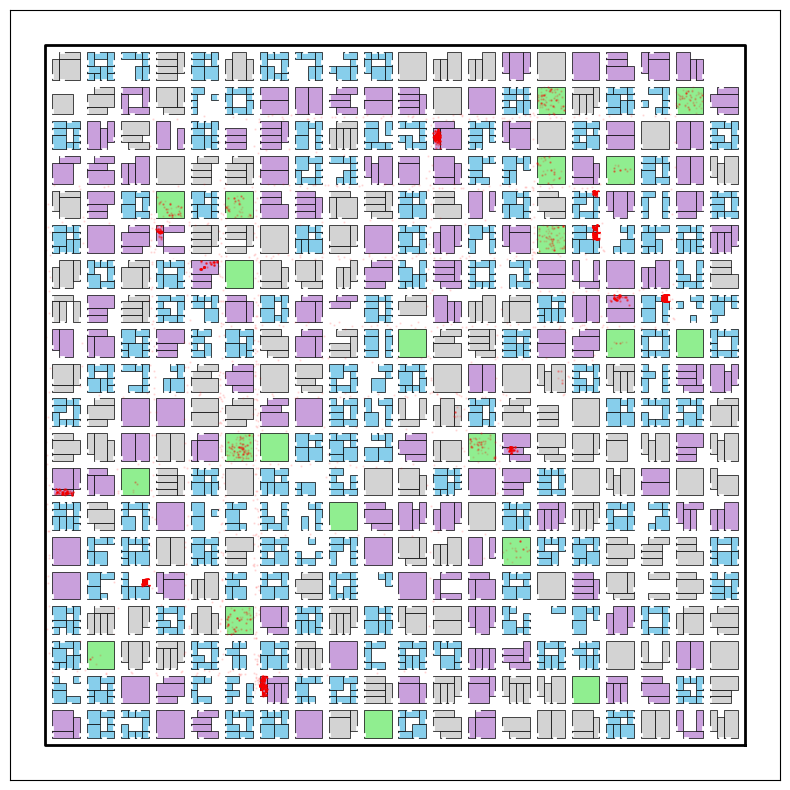

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
clustered_city.plot_city(ax, doors=True, address=False, zorder=1)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.scatter(x=Zach.trajectory.x, 
           y=Zach.trajectory.y, 
           s=0.5, color='red', alpha=0.1)

plt.savefig("random-city-one-user.png")